# Machine Learning

#### Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import lightgbm as lgbm

import pickle

pd.set_option('display.max_columns', None)

## Carregar base de dados

In [2]:
PATH = '../data/processed/'

In [3]:
dataset = pd.read_csv(os.path.join(PATH, 'dataset.csv'), sep=',')
print(dataset.shape)
dataset.head()

(4523, 105)


,BOM,RUIM,DESEMPENHO_ESC,CD_ESCOLA,CAPITAL,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_PUBLIC,GVA_TOTAL,GDP,GDP_CAPITA,COMP_H,COMP_O,COMP_P,COMP_Q,CLUSTER,DEPENDENCIAS_SALAS_AULA,DEPENDENCIAS_SALA_RECURSO,DEPENDENCIAS_TOT_SALAS_AULA,DEPENDENCIAS_CANTINA,DEPENDENCIAS_COPA,DEPENDENCIAS_REFEITORIO,DEPENDENCIAS_SALA_LEITURA,DEPENDENCIAS_TOT_SALA_LEITURA,DEPENDENCIAS_TOT_QUADRA,DEPENDENCIAS_SALA_PROF,DEPENDENCIAS_PATIO_COBERTO,DEPENDENCIAS_PATIO_DESCOBERTO,DEPENDENCIAS_TOT_VESTIARIO,DEPENDENCIAS_LAB_INFO,DEPENDENCIAS_LAB_CIENCIAS,DEPENDENCIAS_LAB_CIENCIA_FISICA_BIOLOGICA,DEPENDENCIAS_TOT_LAB_CIENCIA,DEPENDENCIAS_LAB_MULTIUSO,DEPENDENCIAS_OFICINA,DEPENDENCIAS_DORMITORIO,DEPENDENCIAS_SANITARIO_ADEQ_DEF,DEPENDENCIAS_SANITARIO_AL_MASC,DEPENDENCIAS_SANITARIO_AL_FEM,DEPENDENCIAS_TOT_SANITARIO_AL,DEPENDENCIAS_TOT_SANITARIO_FUNC,DEPENDENCIAS_DEPEND_ADEQ_DEF,DEPENDENCIAS_SALA_ED_FISICA,DEPENDENCIAS_SALA_PROG_ESC_FAMILIA,DEPENDENCIAS_BRINQUEDOTECA,DEPENDENCIAS_SALA_REFORCO,DEPENDENCIAS_AREA_SERVICO,DEPENDENCIAS_SALA_ATENDIMENTO,DEPENDENCIAS_SALA_ENTRETENIMENTO,FORMACAO_APERF/EXTENSIAOCULTURAL,FORMACAO_BACHARELADO/TECNIOLOGO,FORMACAO_DOUTORADO,FORMACAO_ENSINO_MEDIO,FORMACAO_ESPECIALIZACAO,FORMACAO_LICENCIATURA,FORMACAO_MESTRADO,FORMACAO_S/INFO,QTD_SERVIDORES,QTD_PROFESSORES,MEDIA_FORMACOES,QTD_FORMACAO_CONTINUADA,QTD_CARGOS_DISTINTOS,QTD_TOTAL_ALUNOS,QTD_CLASSES,MEDIA_ALUNOS_SALA,STD_ALUNOS_SALA,QTD_CLASSE_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_CLASSE_TIPO_ENSINO MEDIO,QTD_CLASSE_TIPO_CEL,QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_ALUNOS_TIPO_ENSINO MEDIO,QTD_ALUNOS_TIPO_CEL,DIRETORES_QTD_1018,VICE_DIRETOR_QTD_2018,COORDENADORES_QTD_2018,DIRETORES_QTD_5_ANOS,VICE_DIRETOR_QTD_5_ANOS,COORDENADORES_QTD_5_ANOS,DIRETOR_IDADE,DIRETOR_CARGO_CLAS_EXER_IGUAIS,DIRETOR_ANOS_TRAB_CARGO_C,DIRETOR_ANOS_TRAB_CARGO_C.1,DIRETOR_ANOS_TRAB_CARGO_E,DIRETOR_TITULACAO,JORNADA_QTD_DISCIPLINAS_mean,JORNADA_QTD_DISCIPLINAS_std,JORNADA_QTD_DISCIPLINAS_max,JORNADA_QTD_TOTAL_AULAS_mean,JORNADA_QTD_TOTAL_AULAS_std,JORNADA_QTD_TOTAL_AULAS_max,SERVIDORES_IDADE_mean,SERVIDORES_IDADE_std,SERVIDORES_TEMPO_CARGO_C_mean,SERVIDORES_TEMPO_CARGO_C_std,SERVIDORES_CAT_FUNCIONAL_A,SERVIDORES_CAT_FUNCIONAL_F,SERVIDORES_CAT_FUNCIONAL_N,SERVIDORES_CAT_FUNCIONAL_O,SERVIDORES_CAT_FUNCIONAL_P,MATEMATICA,LEITURA,ESCRITA,RELACAO_ALUNO_POR_SERVIDOR,RELACAO_ALUNO_POR_PROFESSOR
0,1.0,7.0,0,24,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,0,35,0,35,1,0,1,1,1,2,1,1,1,0,2,0,1,1,0,0,0,0,1,1,2,2,1,1,0,0,0,0,0,0,0.0,0.101695,0.008475,0.016949,0.016949,0.771186,0.084746,0.0,139,118.0,1.228814,13.0,6,2703,88,30.715909,7.214208,34.0,40.0,0.0,956.0,1229.0,0.0,3.0,6.0,3.0,11.0,19.0,17.0,33.0,1,0.0,0.0,0.0,ESPECIALIZACAO,3.486726,1.768348,10,48.849558,20.847756,108,46.691429,8.700472,10.725714,6.325839,0.794286,0.142857,0.0,0.062857,0.0,4.0,3.0,4.0,19.446043,22.906780
1,0.0,4.0,0,36,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,0,21,1,22,1,0,3,1,1,2,1,1,0,0,2,0,1,1,3,0,0,0,1,1,2,2,0,1,0,0,1,0,0,0,0.0,0.095238,0.011905,0.000000,0.142857,0.738095,0.011905,0.0,92,84.0,1.297619,14.0,4,2164,69,31.362319,8.549116,34.0,29.0,0.0,1189.0,945.0,0.0,4.0,5.0,3.0,13.0,15.0,13.0,50.0,0,18.0,18.0,0.0,ESPECIALIZACAO,2.975000,1.492386,8,46.525000,19.308931,104,45.365385,8.625384,8.586538,5.766152,0.759615,0.173077,0.0,0.067308,0.0,4.0,3.0,4.0,23.521739,25.761905
2,0.0,2.0,0,48,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,0,19,0,19,1,0,0,1,1,1,1,1,0,0,2,0,2,2,1,0,0,0,3,3,6,3,0,0,0,0,0,0,0,0,0.0,0.090909,0.018182,0.000000,0.018182,0.836364,0.036364,0.0,66,55.0,1.163636,4.0,5,1189,35,33.971429,5.695642,0.0,35.0,0.0,0.0,1189.0,0.0,2.0,1.0,2.0,8.0,12.0,10.0,58.0,0,18.0,18.0,2.0,LICENCIATURA,2.125000,0.489246,4,44.375000,16.629409,64,45.729167,8.617582,9.250000,7.293833,0.854167,0.104167,0.0,0.041667,0.0,4.0,3.0,4.0,18.015152,21.618182
3,0.0,2.0,0,59,1,1521.1

#### Remover a coluna de identificação *CD_ESCOLA* e os atributos *BOM* e *RUIM* que foram utilizados para construir a classe alvo
Cada linha representa uma escola, apesar da remoção de CD_ESCOLA, que é necessário já que este não é um atributo para predizer o desempenho escolar, é possível identificar o resultado da predição da escola com os índices do dataset, que permite localizar o *CD_ESCOLA* posteriormente

In [4]:
dataset.drop(['BOM', 'RUIM', 'CD_ESCOLA'], axis=1, inplace=True)

### Renomear a coluna *DESEMPENHO_ESC* para *DESEMPENHO*

In [5]:
dataset = dataset.rename(columns={'DESEMPENHO_ESC': 'DESEMPENHO'})

## Encodificação
Transformar os atributos categóricos para numéricos

### Transformar atributo CLUSTER para One Hot Encoder 

In [6]:
df_cluster_dummie = pd.get_dummies(dataset['CLUSTER'], prefix='CLUSTER_')
dataset = pd.concat([dataset.drop('CLUSTER', axis=1), df_cluster_dummie], axis=1)

In [7]:
# pd.get_dummies(dataset['DIRETOR_TITULACAO'], prefix='DIRETOR_TITULO_').sum() / dataset.shape[0] * 100
df_diretor_titulo_dummie = pd.get_dummies(dataset['DIRETOR_TITULACAO'], prefix='DIRETOR_TITULO_')
dataset = pd.concat([dataset.drop('DIRETOR_TITULACAO', axis=1), df_diretor_titulo_dummie], axis=1)

### Transformar o atributo RURAL_URBAN para o tipo binario

- Urbano -> 1
- Intermediário Adjacente -> 0
- Rural Adjacente -> 0

In [8]:
dataset['RURAL_URBAN'].value_counts(normalize=True) * 100

Urbano                     90.470926
Rural Adjacente             5.328322
Intermediário Adjacente     4.200752
Name: RURAL_URBAN, dtype: float64

In [9]:
dataset['RURAL_URBAN'] = np.where(dataset['RURAL_URBAN'] == 'Urbano', 1, 0)

## Preenchimento dos dados faltantes

In [10]:
missing_values_cols = dataset.isnull().sum()
missing_values_cols[missing_values_cols > 0]

VICE_DIRETOR_QTD_2018       34
COORDENADORES_QTD_2018       6
VICE_DIRETOR_QTD_5_ANOS     34
COORDENADORES_QTD_5_ANOS     6
dtype: int64

In [11]:
dataset['CAPITAL'] = dataset['CAPITAL'].fillna(0)

In [12]:
cols = dataset.columns

imputer = SimpleImputer(strategy='mean')
dataset = imputer.fit_transform(dataset)

dataset = pd.DataFrame(dataset, columns=cols)

## Separacao dos dados
- Treinamento: 80%
- Teste: 20%

In [59]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('DESEMPENHO', axis=1), dataset['DESEMPENHO'], test_size=0.2, random_state=17)

## Modeling

### Validação Cruzada com 10 folds

In [14]:
scale_pos_weight = y_train[y_train==0].count() / y_train[y_train==1].count()

In [15]:
model = lgbm.LGBMClassifier(n_estimators=300, is_imbalanced=True, scale_pos_weight=scale_pos_weight, devide='gpu')
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, n_jobs=-1)

print('Acuracia Media:', np.mean(scores))
print('Desvio Padrao:', np.std(scores))
print(scores)

Acuracia Media: 0.9262025374573393
Desvio Padrao: 0.010557137542819296
[0.92541436 0.92265193 0.93370166 0.93093923 0.94751381 0.92541436
 0.9198895  0.90331492 0.92520776 0.92797784]


### Avaliação no conjunto de teste

In [16]:
model = lgbm.LGBMClassifier(n_estimators=300, is_imbalanced=True, scale_pos_weight=scale_pos_weight, devide='gpu')
model.fit(X_train, y_train)
pred = model.predict(X_test)

Acc score: 0.912707182320442
F1 score: 0.740983606557377
AUC ROC: 0.8566832710668328


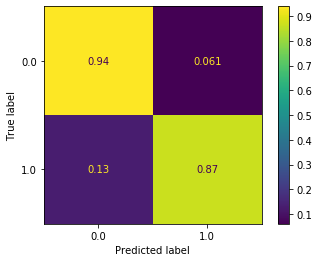

In [60]:
print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))
plot_confusion_matrix(model, X_test, y_test, normalize='true')

### Modelagem com o mesmo classificador, LGBM, porem removendo o atributo relacionado ao Ensino Medio
O ensino medio apresenta um SARESP extremamente desbalanceado, com um desempenho ruim em na maioria dos casos. O modelo conseguiu aprender que uma quantidade alta de alunos do ensino medio e/ou muitas turmas destas vao impactar negativamente no desempenho do SARESP escolar. Esses atributos serao removidos, para testar a performance do modelo sem estes, mais importante que isto, para aumentar a possibilidade do modelo explorar os outros atributos, o que sera extremamente util para analisar o impacto das caracteristicas.

In [19]:
cols_to_drop = ['QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS', 'QTD_ALUNOS_TIPO_ENSINO MEDIO', 'QTD_ALUNOS_TIPO_CEL', 'QTD_CLASSE_TIPO_ENSINO MEDIO', 'QTD_CLASSE_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS', 'QTD_CLASSE_TIPO_CEL']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(cols_to_drop + ['DESEMPENHO'], axis=1), dataset['DESEMPENHO'], test_size=0.2, random_state=17)

In [21]:
model2 = lgbm.LGBMClassifier(n_estimators=300, is_imbalanced=True, scale_pos_weight=scale_pos_weight, devide='gpu')
model2.fit(X_train, y_train)
pred = model2.predict(X_test)

Acc score: 0.912707182320442
F1 score: 0.740983606557377
AUC ROC: 0.8566832710668328


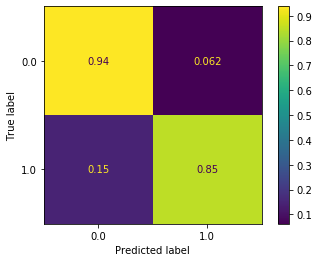

In [57]:
print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))
plot_confusion_matrix(model2, X_test, y_test, normalize='true')

### Modelagem com uma Arvore de Decisao simples (com profundidade pequena)
Esse modelo sera utilizado para descobrir regras que separam as escolas com desempenho ruins das boas.

In [23]:
# # remover colunas relacionadas a dependencias - ANALISAR
# dependencias_cols = list(filter(lambda x: True if 'DEPENDENCIAS' in x else False, dataset.columns))
# dataset.drop(dependencias_cols, axis=1,inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(cols_to_drop + ['DESEMPENHO'], axis=1), dataset['DESEMPENHO'], test_size=0.2, random_state=17)

In [25]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=17)
scores = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=10, n_jobs=-1)

print('Acuracia Media:', np.mean(scores))
print('Desvio Padrao:', np.std(scores))
print(scores)

Acuracia Media: 0.9121026614223842
Desvio Padrao: 0.011202469712932348
[0.9198895  0.90883978 0.91436464 0.90883978 0.93646409 0.92265193
 0.89502762 0.90331492 0.90304709 0.90858726]


Acc score: 0.912707182320442
F1 score: 0.740983606557377
AUC ROC: 0.8566832710668328


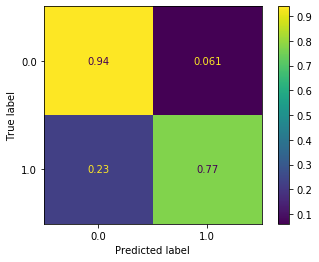

In [55]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=17)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)

print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))
plot_confusion_matrix(tree, X_test, y_test, normalize='true')

### Desempenho no conjunto de treinamento
Apenas para verificiar se nao houve overfitting

In [36]:
pred = tree.predict(X_train)
print('Acc score:', accuracy_score(y_train, pred))
print('F1 score:', f1_score(y_train, pred))
print('AUC ROC:', roc_auc_score(y_train, pred))

Acc score: 0.9154228855721394
F1 score: 0.7296819787985867
AUC ROC: 0.8317971295435471


## Exportar modelo

In [37]:
with open('../models/model_1.pkl', 'wb') as f:
    pickle.dump(model, f)
    
with open('../models/model_2.pkl', 'wb') as f:
    pickle.dump(model2, f)
    
with open('../models/model_tree.pkl', 'wb') as f:
    pickle.dump(tree, f)

### Conjunto de dados completo (final)

In [38]:
dataset.to_csv('../data/processed/dataset_final.csv', index=False)